#### Customer data

In [1]:
# Importing lots of stuff

import logging
import threading
import itertools
import pandas as pd
import numpy as np 
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (BayesRidgeRegressor)                
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing
import statsmodels.api as sm
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)
'''

"\nwith open('credentials_as_monitor_demo.json', encoding='utf-8') as F:\n    credentials = json.loads(F.read())\n    \ndb_schema=None\ndb = Database(credentials=credentials)\nprint (db)\ndb_schema=None\nfm = FileModelStore()\ndb = Database(credentials=credentials, model_store=fm)\nprint (db)\n"

In [26]:
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)

In [33]:

df = df_input.resample('1H').asfreq().dropna()

In [34]:
df.index

DatetimeIndex(['2019-09-15 00:00:00', '2019-09-15 01:00:00',
               '2019-09-15 02:00:00', '2019-09-15 03:00:00',
               '2019-09-15 04:00:00', '2019-09-15 05:00:00',
               '2019-09-15 06:00:00', '2019-09-15 07:00:00',
               '2019-09-15 08:00:00', '2019-09-15 09:00:00',
               ...
               '2020-08-31 11:00:00', '2020-08-31 12:00:00',
               '2020-08-31 13:00:00', '2020-08-31 14:00:00',
               '2020-08-31 15:00:00', '2020-08-31 16:00:00',
               '2020-08-31 17:00:00', '2020-08-31 18:00:00',
               '2020-08-31 19:00:00', '2020-08-31 20:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8336, freq=None)

In [35]:
df

,TEMP_AIR,UMIDADE_REL,KW,KW2
timestamp,,,,
2019-09-15 00:00:00,18.7,80.0,690.480000,69.048000
2019-09-15 01:00:00,18.2,83.0,685.440000,68.544000
2019-09-15 02:00:00,18.2,83.0,656.880000,65.688000
2019-09-15 03:00:00,18.2,83.0,655.200000,65.520000
2019-09-15 04:00:00,18.3,82.0,660.240000,66.024000
...,...,...,...,...
2020-08-31 16:00:00,20.8,68.0,525.840027,52.584003
2020-08-31 17:00:00,19.6,72.0,504.000000,50.400000
2020-08-31 18:00:00,19.5,75.0,535.919983,53.591998


In [36]:
ndif_[0]

-5.0

(8336,)


Text(0.5, 1.0, 'original')

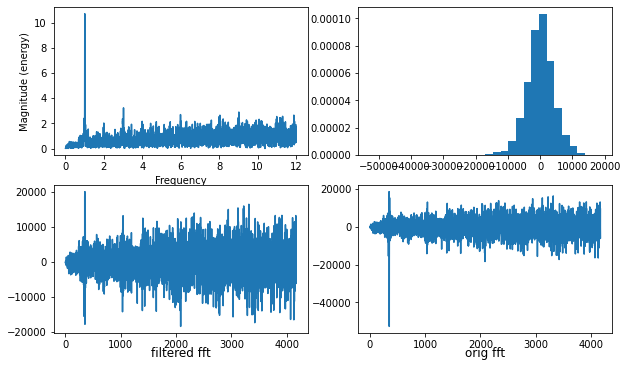

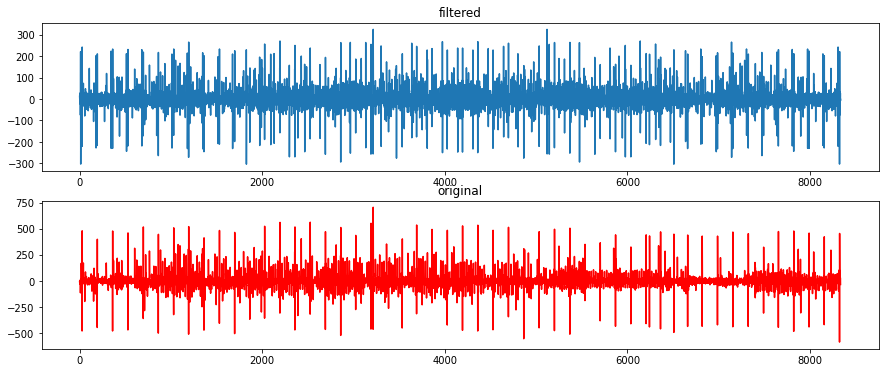

In [37]:
# seasonality - once a day stands out, every 3 days
ndif_ = np.concatenate((np.array([-5]), np.diff(df['KW'])))


ndif_fft = sp.fft.rfft(ndif_).real


print (ndif_.shape)
fig, ax = plt.subplots(2,2,figsize=(10,6))
spectrum,_,_ = ax[0,0].magnitude_spectrum(ndif_, Fs=24)

t = ax[0,1].hist(ndif_fft, bins=30, density=True)
ax[1,0].set_title('histogram freq')

ndif_filt_fft = np.where(np.abs(ndif_fft) > 20000, 20000, ndif_fft) #ndif_fft, 20000)

ndif2 = sp.fft.irfft(ndif_filt_fft)

#ndif2[ndif2 > 500] = 500
#ndif2[ndif2 < -500] = -500

ndif2_nonfilt = sp.fft.irfft(ndif_fft)
#ndif2[ndif2 < -3.5] = -3.5
t = ax[1,0].plot(ndif_filt_fft)
ax[1,0].set_title('filtered fft', y=-0.2)

t = ax[1,1].plot(ndif_fft)
ax[1,1].set_title('orig fft', y=-0.2)


fig, ax = plt.subplots(2,1,figsize=(15,6), squeeze=False)
t = ax[0,0].plot(ndif2)
ax[0,0].set_title('filtered')

t = ax[1,0].plot(ndif_, color='red')
ax[1,0].set_title('original')
#print(ndif_.mode())



In [38]:
ndif = ndif_
ndif.shape
df['diff'] = ndif

In [39]:
ptfd = preprocessing.PowerTransformer()
kw_boxed = ptfd.fit_transform(ndif.reshape(-1, 1))
kw_log = np.lib.scimath.log(np.abs(ndif) + 10e-4)


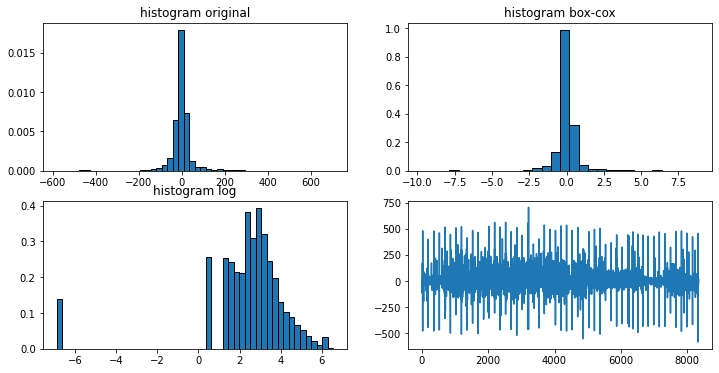

In [40]:
fig, ax = plt.subplots(2, 2,figsize=(12,6), squeeze=False)

ax[0,0].hist(ndif, bins=50, density = True, histtype='bar', ec='black')
ax[0,0].set_title('histogram original')
ax[0,1].hist(kw_boxed, bins=30, density = True, histtype='bar', ec='black')
ax[0,1].set_title('histogram box-cox')
ax[1,0].hist(kw_log, bins=50, density = True, histtype='bar', ec='black')
ax[1,0].set_title('histogram log')
ax[1,1].plot(ndif)

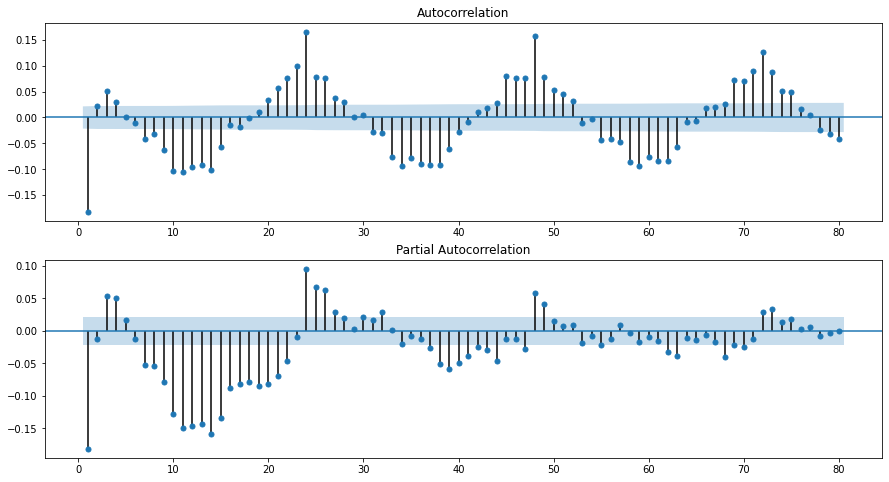

In [11]:
#
# p = 1, q = 1 + seasonal effects
#
fig, ax = plt.subplots(2, 1, figsize=(15, 8), squeeze=False)
x = sm.graphics.tsa.plot_acf(ndif, lags=80, ax=ax[0,0], zero=False)
x = sm.graphics.tsa.plot_pacf(ndif, lags=80, ax=ax[1,0], zero=False)

In [25]:
# try a multi-lag difference ..
lag = 12
nNdif = ndif[lag:] - ndif[:len(ndif) - lag]

In [27]:
nNdif.shape

(8323,)

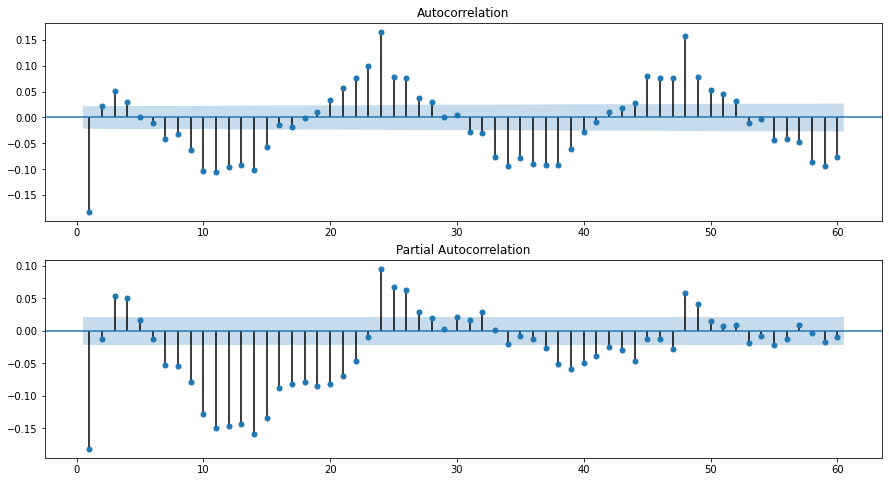

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), squeeze=False)
x = sm.graphics.tsa.plot_acf(ndif_, lags=60, ax=ax[0,0], zero=False)
x = sm.graphics.tsa.plot_pacf(ndif_, lags=60, ax=ax[1,0], zero=False)

In [118]:

ptf = preprocessing.PowerTransformer(method='box-cox')
kw_boxed = ptf.fit_transform(df_input['KW'].values.reshape(-1,1))
df_input['KW_box'] = kw_boxed

df_input['KW_log'] = np.lib.scimath.log(df_input['KW'].values)

#kw_unboxed = ptf.inverse_transform(kw_boxed)
#kw_unboxed - df_input['KW'].values.reshape(-1,1)

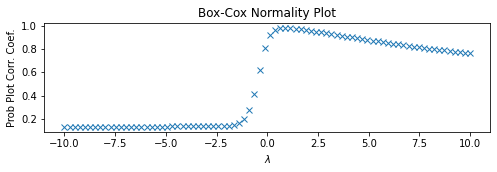

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(8,2), squeeze=False)
prob = sp.stats.boxcox_normplot(df_input['KW'].values, -10, 10, plot=ax[0,0])


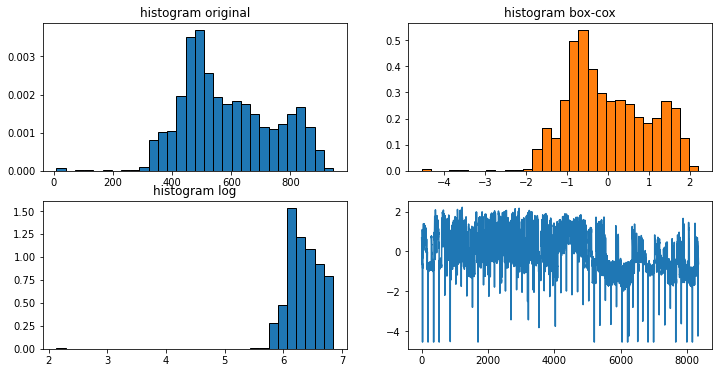

In [120]:
fig, ax = plt.subplots(2, 2,figsize=(12,6), squeeze=False)

ax[0,0].hist(df_input['KW'], bins=30, density = True, histtype='bar', ec='black')
ax[0,0].set_title('histogram original')
ax[0,1].hist(df_input['KW_box'], bins=30, density = True, histtype='bar', ec='black')
#ax[0,1].hist(df_input['KW_box'], bins=30, density = True, histtype='bar', ec='black')
ax[0,1].set_title('histogram box-cox')
ax[1,0].hist(df_input['KW_log'], bins=30, density = True, histtype='bar', ec='black')
ax[1,0].set_title('histogram log')
ax[1,1].plot(df_input.index, df_input['KW_box'])


In [97]:
# Pick scaled data 

#    - choosing logarithmic scale now

df_scaled = df_input[['KW_log']].copy()
df_scaled.rename(columns={'KW_log':'KW'}, inplace=True)

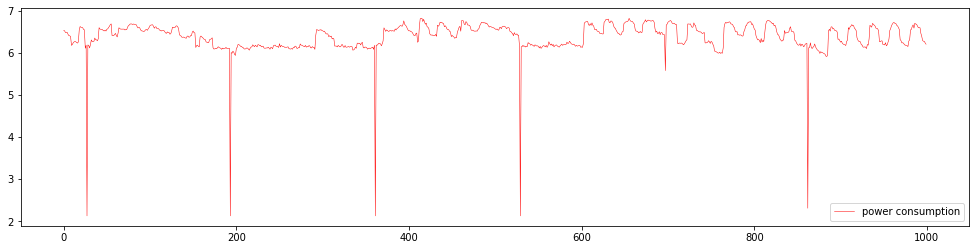

In [98]:
dfg = df_scaled[0:1000]


fig, ax = plt.subplots(1, 1,figsize=(17,4), squeeze=False)
ax[0,0].plot(dfg.index, dfg['KW'], lw=0.5, color='red', label='power consumption')
[ax[i,0].legend() for i in range(1)]
#[ax[i].set_xticks([]) for i in range(4)]
#[ax[i].set_yticks([]) for i in range(5)]

In [31]:
# stationary ? No
import statsmodels.api as sm
sm.tsa.stattools.adfuller(df_scaled)[1]

1.0776703376094801e-11

In [32]:
sm.tsa.stattools.kpss(df_scaled)[1]

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


0.01

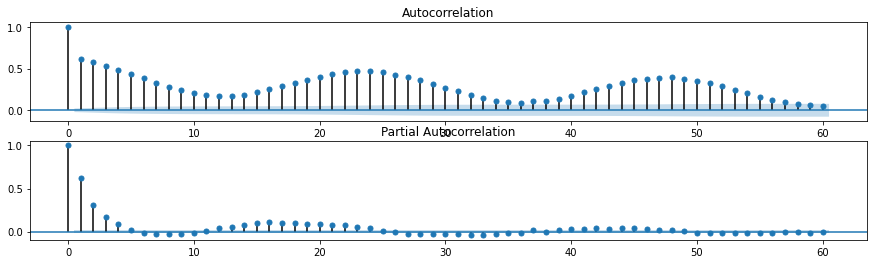

In [106]:
#
# p = 2, q = 0 + seasonal effects
#
fig, ax = plt.subplots(2, 1, figsize=(15, 4), squeeze=False)
x = sm.graphics.tsa.plot_acf(df_scaled, lags=60, ax=ax[0,0])
x = sm.graphics.tsa.plot_pacf(df_scaled, lags=60, ax=ax[1,0])

In [48]:
#
#  Maybe it's better to go with 
# p = 1, i = 1 and q = 1 + seasonal effects
#
df_scal_diff = df_scaled.diff().dropna()
fig, ax = plt.subplots(2, 1, figsize=(15, 5), squeeze=False)
x = sm.graphics.tsa.plot_acf(df_scal_diff, lags=40, ax=ax[0,0])
x = sm.graphics.tsa.plot_pacf(df_scal_diff, lags=40, ax=ax[1,0])

NameError: name 'df_scaled' is not defined

In [42]:
df['diff']

timestamp
2019-09-15 00:00:00    -5.000000
2019-09-15 01:00:00    -5.040000
2019-09-15 02:00:00   -28.560000
2019-09-15 03:00:00    -1.680000
2019-09-15 04:00:00     5.040000
                         ...    
2020-08-31 16:00:00   -23.519959
2020-08-31 17:00:00   -21.840027
2020-08-31 18:00:00    31.919983
2020-08-31 19:00:00   -18.479980
2020-08-31 20:00:00   -31.920013
Name: diff, Length: 8336, dtype: float64

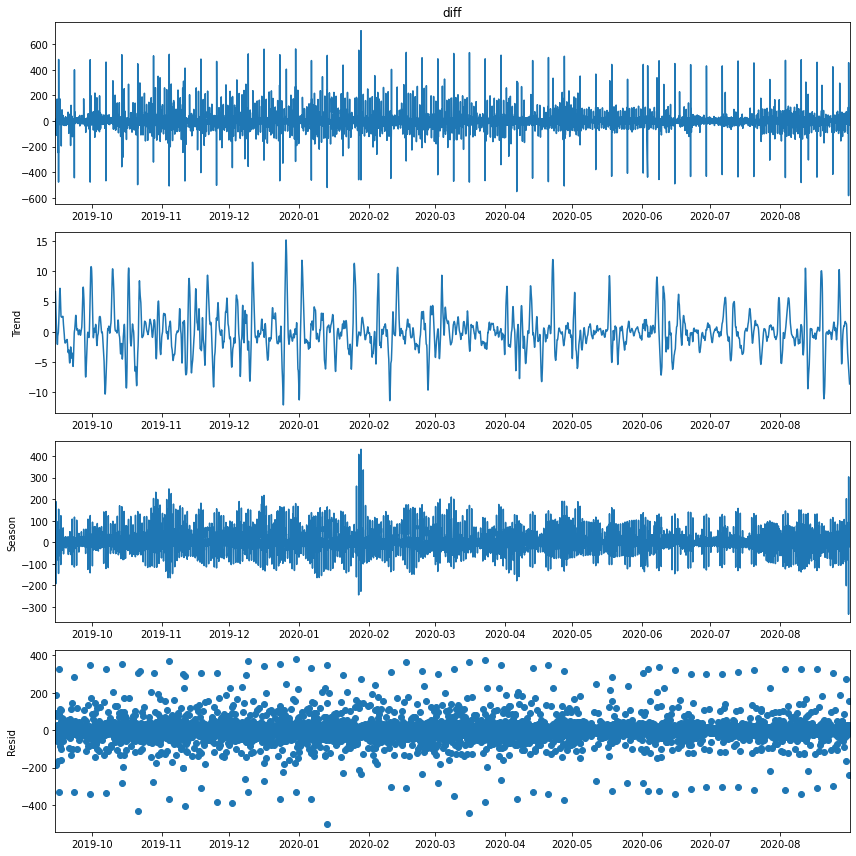

In [53]:
# we have a seasonal component here ...

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure',figsize=(12,12))
stl = STL(df['diff'], period=24) # , period=12, seasonal=19, trend=31, robust=True)
res1 = stl.fit()
fig = res1.plot()

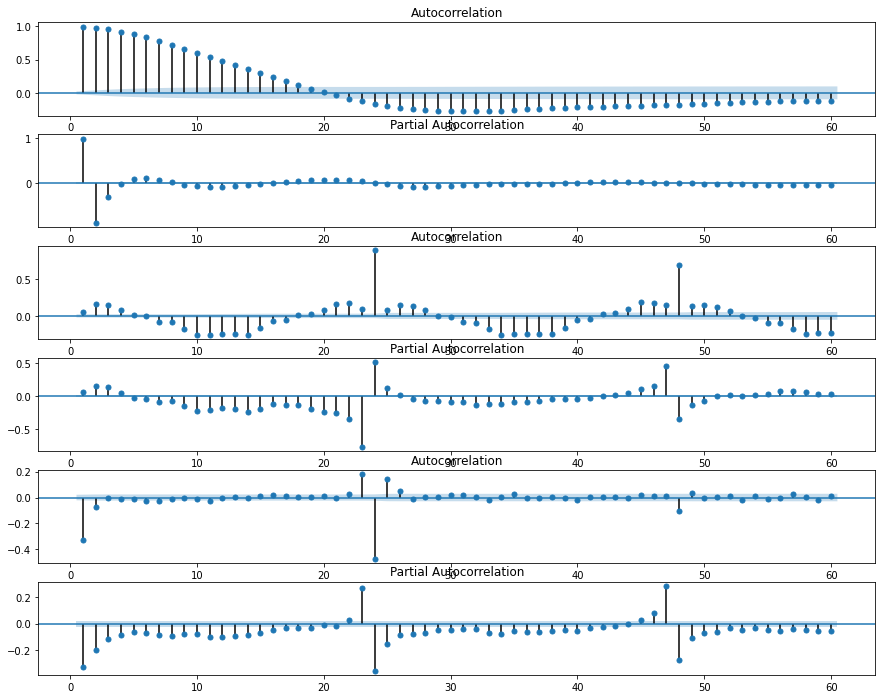

In [44]:
#
# p = 2, q = 0 + seasonal effects
#
fig, ax = plt.subplots(6, 1, figsize=(15, 12), squeeze=False)
x = sm.graphics.tsa.plot_acf(res.trend, lags=60, ax=ax[0,0], zero=False)
x = sm.graphics.tsa.plot_pacf(res.trend, lags=60, ax=ax[1,0], zero=False)
x = sm.graphics.tsa.plot_acf(res.seasonal, lags=60, ax=ax[2,0], zero=False)
x = sm.graphics.tsa.plot_pacf(res.seasonal, lags=60, ax=ax[3,0], zero=False)
x = sm.graphics.tsa.plot_acf(res.resid, lags=60, ax=ax[4,0], zero=False)
x = sm.graphics.tsa.plot_pacf(res.resid, lags=60, ax=ax[5,0], zero=False)


In [85]:
# Combine LOESS with ARIMA
stlf111 = STLForecast(ndif[0:6000], ARIMA, model_kwargs=dict(order=(1,0,1), trend="n"), period=7*24)
stlf200 = STLForecast(ndif[0:6000], ARIMA, model_kwargs=dict(order=(4,0,2), trend="n"), period=7*24)

In [86]:
plt.rc('figure',figsize=(18,4))

#kws = df[0:2000].reset_index().drop(columns='timestamp')

stlf_res111 = stlf111.fit()
stlf_res200 = stlf200.fit()

n_fore = 120
forecast111 = stlf_res111.forecast(n_fore)
forecast200 = stlf_res200.forecast(n_fore)



/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  params_ma *= 0
/home/markus/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  from statsmodels.tools.sm_exceptions import ConvergenceWarning


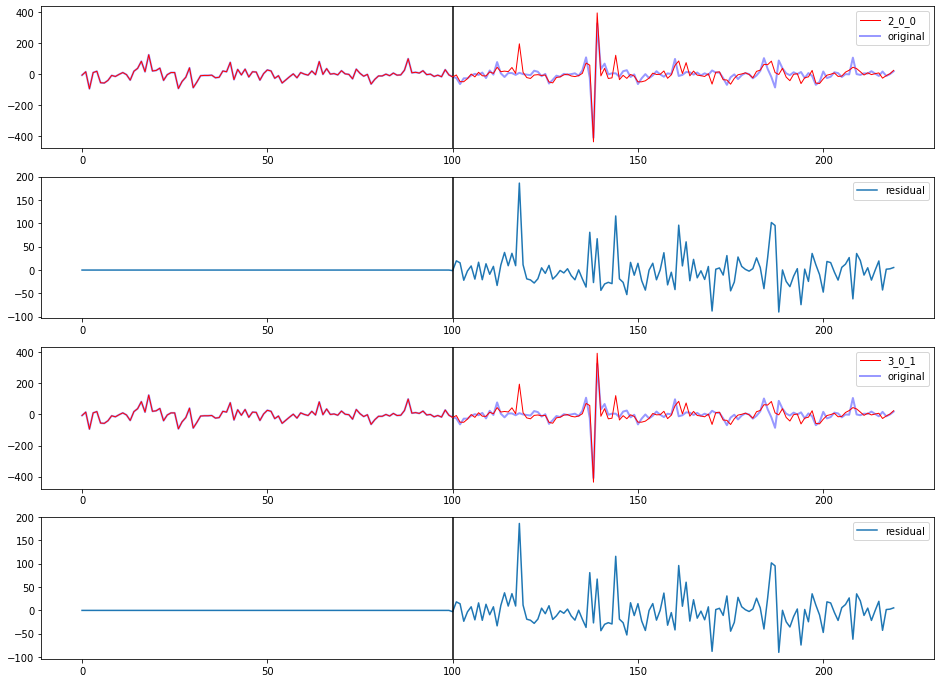

In [87]:
cat111 = np.concatenate((ndif[5900:6000], forecast111))
cat200 = np.concatenate((ndif[5900:6000], forecast200))

fig, ax = plt.subplots(4, 1, figsize=(16,12), squeeze=False)
cnt = 0
#ax[cnt,0].plot(np.concatenate((ndif[5900:6000], forecast111)), color='orange', lw=1, label='1_1_1', zorder=10)
ax[cnt,0].plot(cat111, color='red', lw=1, label='2_0_0', zorder=10)
ax[cnt,0].plot(ndif[5900:6000 + n_fore], color='blue', lw=2, label='original', alpha=0.4)
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()
cnt = 1
ax[cnt,0].plot(cat111 - ndif[5900:6000 + n_fore], label='residual')
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()

cnt = 2
#ax[cnt,0].plot(np.concatenate((ndif[5900:6000], forecast111)), color='orange', lw=1, label='1_1_1', zorder=10)
ax[cnt,0].plot(cat200, color='red', lw=1, label='3_0_1', zorder=10)
ax[cnt,0].plot(ndif[5900:6000 + n_fore], color='blue', lw=2, label='original', alpha=0.4)
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()
cnt = 3
ax[cnt,0].plot(cat200 - ndif[5900:6000 + n_fore], label='residual')
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()


In [89]:
print('RMSE111: ', sm.tools.eval_measures.rmse(forecast111[0:24], ndif[6000:6000 + 24]),
      '\nRMSE200: ', sm.tools.eval_measures.rmse(forecast200[0:24], ndif[6000:6000 + 24]))

RMSE111:  42.531271986168726 
RMSE200:  42.53732468305788


In [101]:
print(stlf_res111.summary(),'\n',stlf_res200.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 6000
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -29571.395
Date:                Thu, 22 Oct 2020   AIC                          59148.790
Time:                        15:47:20   BIC                          59168.888
Sample:                             0   HQIC                         59155.769
                               - 6000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0871      0.026      3.399      0.001       0.037       0.137
ma.L1         -0.4174      0.025    -16.385      0.000      -0.467      -0.367
sigma2      1117.9173     11.221     99.627      0.0

In [74]:
# residual autocorrelation test

from statsmodels.stats.stattools import durbin_watson

print(durbin_watson(stlf_res111.result.resid), durbin_watson(stlf_res200.result.resid))

2.59068593264466 2.59068593264466


In [255]:
# Trying "plain" ARIMA from pyflux
import pyflux as pf

model = pf.ARIMA(data=df_scaled[0:6000], ar=2, ma=0, target='KW', family=pf.Normal())

In [256]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: KW                                  Method: MLE                                       
Start Date: 2                                           Log Likelihood: -1287.8973                        
End Date: 5999                                          AIC: 2583.7946                                    
Number of observations: 5998                            BIC: 2610.5913                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0288     0.0042     6.7918   0.0      (0.0205 | 0.0372)        
AR(1)                                

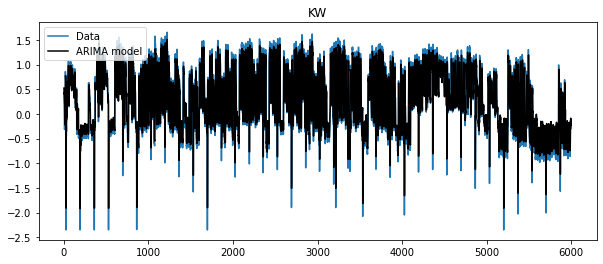

In [259]:
model.plot_fit(figsize=(10,4))

In [72]:
from tbats import BATS, TBATS
estimator = TBATS(
    seasonal_periods=[24, 7*24],
    use_arma_errors=True,  # shall try only models without ARMA
    use_box_cox=True  # will not use Box-Cox
)



In [73]:
tbats_fit = estimator.fit(df['diff'][0:6000])

/home/markus/.local/lib/python3.8/site-packages/tbats/error/ExceptionHandler.py:13: InputArgsWarning: Box-Cox transformation (use_box_cox) was forced to True but there are negative values in input series. Setting use_box_cox to False.
  warnings.warn(message, warning_type)
/home/markus/.local/lib/python3.8/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


In [78]:
tbats_fore = tbats_fit.forecast(steps=240)

In [79]:
tbats_fore[0:24]

array([-6.75741866, -5.74678831, -4.89026725, -4.16435563, -3.54913704,
       -3.02773207, -2.58583526, -2.21132254, -1.89391863, -1.6249151 ,
       -1.39693145, -1.20371265, -1.03995745, -0.901173  , -0.78355155,
       -0.683866  , -0.59938133, -0.52777958, -0.46709626, -0.41566644,
       -0.37207906, -0.33513825, -0.30383048, -0.27729677])

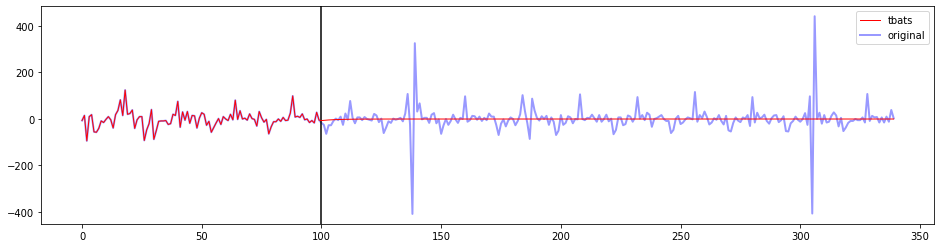

In [80]:
cat_tbats = np.concatenate((df['diff'][5900:6000].values, tbats_fore))

fig, ax = plt.subplots(1, 1, figsize=(16,4), squeeze=False)
cnt = 0
ax[cnt,0].plot(cat_tbats, color='red', lw=1, label='tbats', zorder=10)
ax[cnt,0].plot(ndif[5900:6000 + 240], color='blue', lw=2, label='original', alpha=0.4)
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()

In [83]:
tbats_fit.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: []\nSeasonal harmonics []\nARMA errors (p, q): (0, 0)\nSmoothing (Alpha): -0.168408\nTrend (Beta): 0.030261\nDamping Parameter (Phi): 0.847512\nSeasonal Parameters (Gamma): []\nAR coefficients []\nMA coefficients []\nSeed vector [-39.04001047   7.08727045]\n\nAIC 103198.753040'

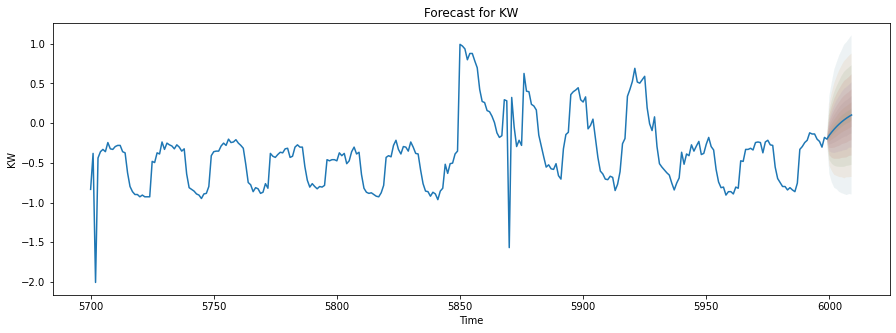

In [271]:
# Hmmm - I wouldn't have expected that
# not sure whether this is useful
#
model.plot_predict(h=10,past_values=300,figsize=(15,5))

In [309]:
# looking for volatility

model = pf.GARCH(p=1, q=1, data=df_scaled[0:1500])

model.adjust_prior(1, pf.TruncatedNormal(0.01, 0.5, lower=0.0, upper=1.0))
model.adjust_prior(2, pf.TruncatedNormal(0.97, 0.5, lower=0.0, upper=1.0))

In [312]:
model.plot_z([1,2], figsize=(10,4))

ValueError: No information on latent variable to plot!

<Figure size 720x288 with 0 Axes>

In [283]:
print(model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      TruncatedNormal mu0: 0.01, sigma0: 0.5    Normal     None      
2        p(1)                      TruncatedNormal mu0: 0.97, sigma0: 0.5    Normal     None      
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      


In [288]:
#
# MCMC made easy
#
x = model.fit('M-H', nsims=20000)  # size of the array for the posterior density in latent_variables.z_list

Acceptance rate of Metropolis-Hastings is 0.0003
Acceptance rate of Metropolis-Hastings is 0.0265
Acceptance rate of Metropolis-Hastings is 0.403375
Acceptance rate of Metropolis-Hastings is 0.316

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.319725


In [298]:
mylatent = model.latent_variables

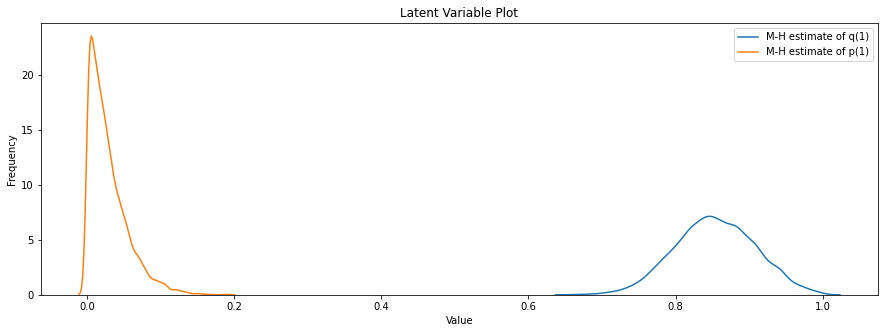

In [71]:
model.plot_z([1,2])

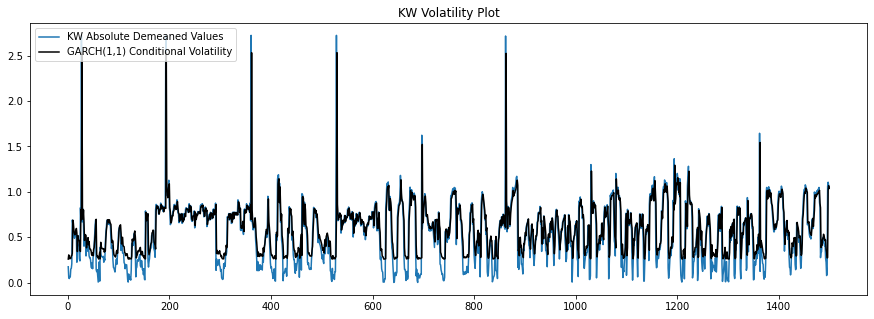

In [72]:
model.plot_fit(figsize=(15,5))

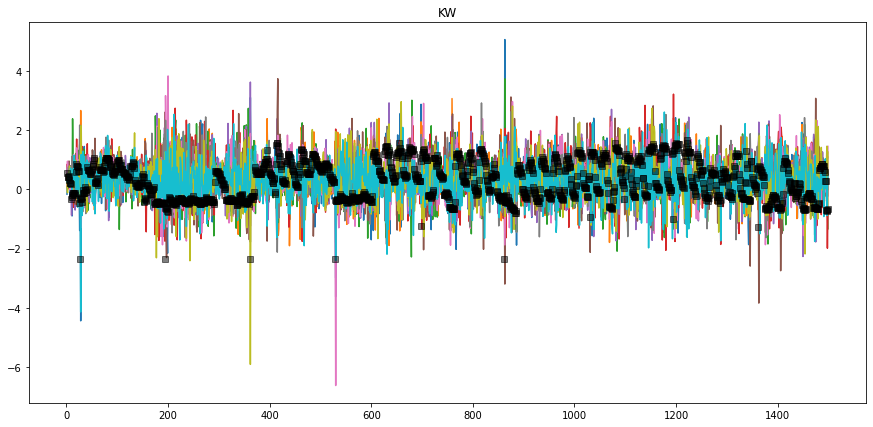

In [73]:
model.plot_sample(nsims=10, figsize=(15,7))

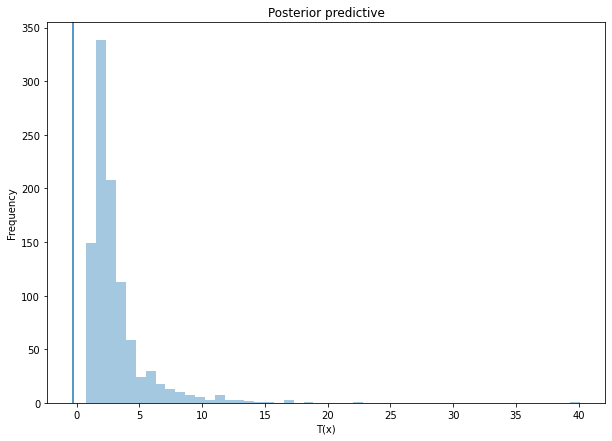

In [74]:
from scipy.stats import kurtosis
model.plot_ppc(T=kurtosis)

In [77]:
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: KW                                  Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -1224.9757            
End Date: 1499                                          AIC: 2457.9514348468665                           
Number of observations: 1499                            BIC: 2479.201648839277                            
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Vol Constant                             0.0653             0.0652             (0.0546 | 0.0775)        
q(1)                                     0.

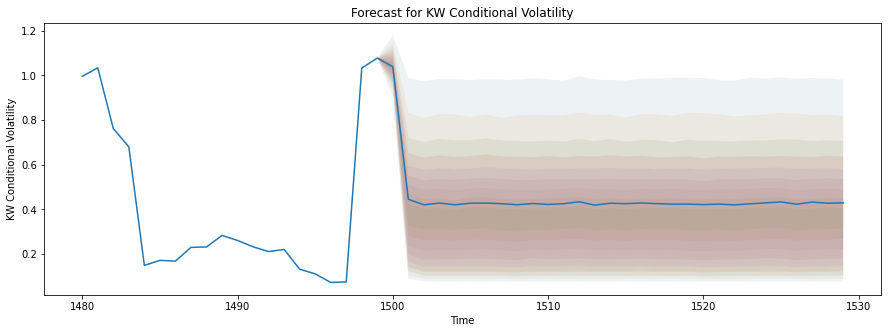

In [78]:
#
# Hmm, I guess I have to look into pyflux code ...
#
model.plot_predict(h=30, figsize=(15,5))